In [3]:
import zipfile
import os

# Extract frames.zip
with zipfile.ZipFile('/content/frames.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/frames')

# Extract lane-masks.zip
with zipfile.ZipFile('/content/lane-masks.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/lane-masks')

# Verify extraction
print("Frames directory contents:", os.listdir('/content/frames')[:5])
print("Lane-masks directory contents:", os.listdir('/content/lane-masks')[:5])

Frames directory contents: ['frames']
Lane-masks directory contents: ['lane-masks']


In [4]:
import os

# Check contents of the extracted folders
print("Frames subdirectory contents:", os.listdir('/content/frames'))
print("Lane-masks subdirectory contents:", os.listdir('/content/lane-masks'))


Frames subdirectory contents: ['frames']
Lane-masks subdirectory contents: ['lane-masks']


In [5]:
image_dir = '/content/frames/frames'
mask_dir = '/content/lane-masks/lane-masks'


In [6]:
print("Actual frames contents:", os.listdir(image_dir)[:5])
print("Actual lane-masks contents:", os.listdir(mask_dir)[:5])


Actual frames contents: ['0313-2_29400.jpg', '0313-2_975.jpg', '0313-1_7240.jpg', '0531_1492638387249489975.jpg', '0313-1_10760.jpg']
Actual lane-masks contents: ['0313-2_29400.jpg', '0313-2_975.jpg', '0313-1_7240.jpg', '0531_1492638387249489975.jpg', '0313-1_10760.jpg']


In [9]:
import os
import cv2
import numpy as np

def load_data(image_dir, mask_dir, target_size=(256, 256)):
    images = []
    masks = []
    for img_name in sorted(os.listdir(image_dir)):
        if not img_name.endswith(('.jpg', '.png')):
            continue
        img_path = os.path.join(image_dir, img_name)
        mask_path = os.path.join(mask_dir, img_name)
        image = cv2.imread(img_path)
        image = cv2.resize(image, target_size)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, target_size)
        image = image / 255.0
        mask = (mask > 128).astype(np.float32)  # Binarize mask
        images.append(image)
        masks.append(mask[..., np.newaxis])  # Add channel dimension

    return np.array(images), np.array(masks)

# Execute this cell before trying to load the dataset


In [10]:
# Load the dataset
images, masks = load_data(image_dir, mask_dir)


In [12]:
from sklearn.model_selection import train_test_split
train_images, val_images, train_masks, val_masks = train_test_split(
    images, masks, test_size=0.2, random_state=42
)


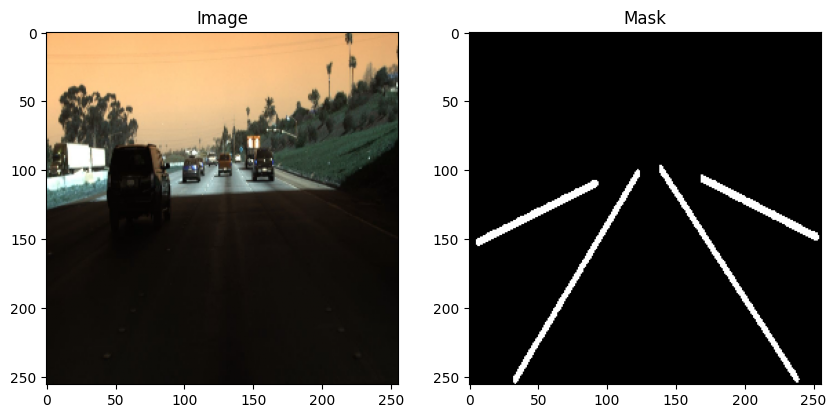

In [13]:
import matplotlib.pyplot as plt

# Visualize a sample image and its mask
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Image')
plt.imshow(train_images[0])  # Display the first training image
plt.subplot(1, 2, 2)
plt.title('Mask')
plt.imshow(train_masks[0].squeeze(), cmap='gray')  # Display the corresponding mask
plt.show()


In [14]:
from tensorflow.keras import layers, Model
import tensorflow as tf

def build_unet(input_shape):
    inputs = tf.keras.Input(input_shape)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    # Bottleneck
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)

    # Decoder
    u1 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c3)
    u1 = layers.concatenate([u1, c2])
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u1)
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c4)

    u2 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c4)
    u2 = layers.concatenate([u2, c1])
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c5)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c5)
    return Model(inputs, outputs)

# Define and compile the model
input_shape = (256, 256, 3)
unet_model = build_unet(input_shape)
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = unet_model.fit(
    train_images, train_masks,
    validation_data=(val_images, val_masks),
    batch_size=16, epochs=10
)


Epoch 1/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 48s 137ms/step - accuracy: 0.9289 - loss: 0.2555 - val_accuracy: 0.9575 - val_loss: 0.1483
Epoch 2/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 0.9583 - loss: 0.1414 - val_accuracy: 0.9655 - val_loss: 0.1052
Epoch 3/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 0.9667 - loss: 0.0955 - val_accuracy: 0.9715 - val_loss: 0.0787
Epoch 4/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 0.9713 - loss: 0.0779 - val_accuracy: 0.9749 - val_loss: 0.0681
Epoch 5/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 0.9743 - loss: 0.0681 - val_accuracy: 0.9757 - val_loss: 0.0642
Epoch 6/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 0.9759 - loss: 0.0637 - val_accuracy: 0.9761 - val_loss: 0.0626
Epoch 7/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 0.9766 - loss: 0.0608 - val_accuracy: 0.9771 - val_loss: 0.0597
Epoch 8/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 0.9775 - loss: 0.0576 -

In [15]:
val_loss, val_accuracy = unet_model.evaluate(val_images, val_masks)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")


23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 243ms/step - accuracy: 0.9789 - loss: 0.0542
Validation Loss: 0.05502282455563545
Validation Accuracy: 0.9785299897193909


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


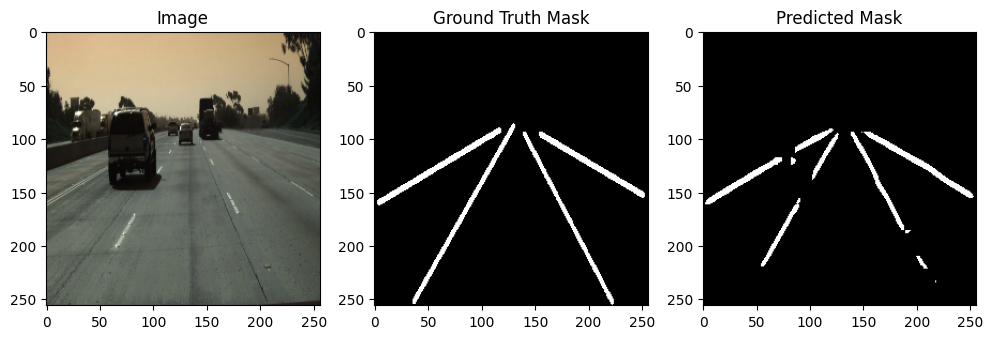

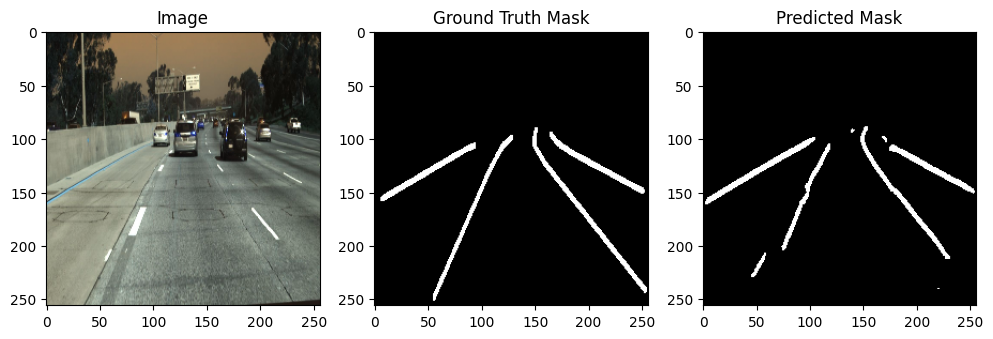

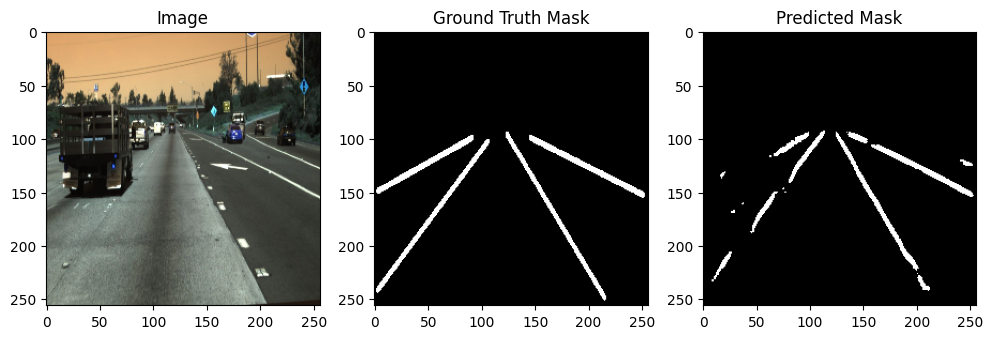

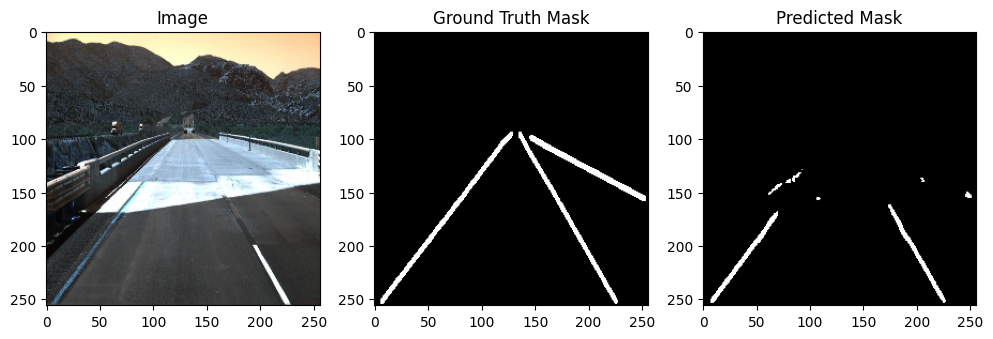

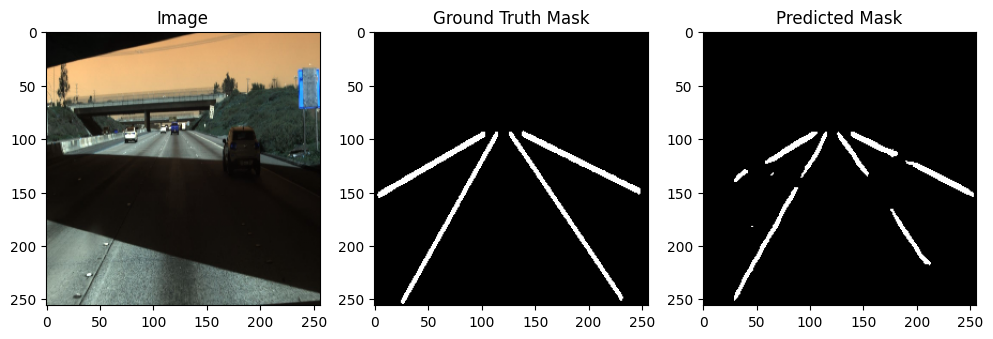

In [16]:
# Visualize predictions
preds = unet_model.predict(val_images[:5])  # Predict for the first 5 validation images
preds = (preds > 0.5).astype(np.uint8)  # Apply threshold to binarize predictions

import matplotlib.pyplot as plt
for i in range(5):
    plt.figure(figsize=(12, 4))

    # Original image
    plt.subplot(1, 3, 1)
    plt.title('Image')
    plt.imshow(val_images[i])

    # Ground truth mask
    plt.subplot(1, 3, 2)
    plt.title('Ground Truth Mask')
    plt.imshow(val_masks[i].squeeze(), cmap='gray')

    # Predicted mask
    plt.subplot(1, 3, 3)
    plt.title('Predicted Mask')
    plt.imshow(preds[i].squeeze(), cmap='gray')

    plt.show()


In [28]:
sample_image = (val_images[0] * 255).astype(np.uint8)  # Convert from float to uint8


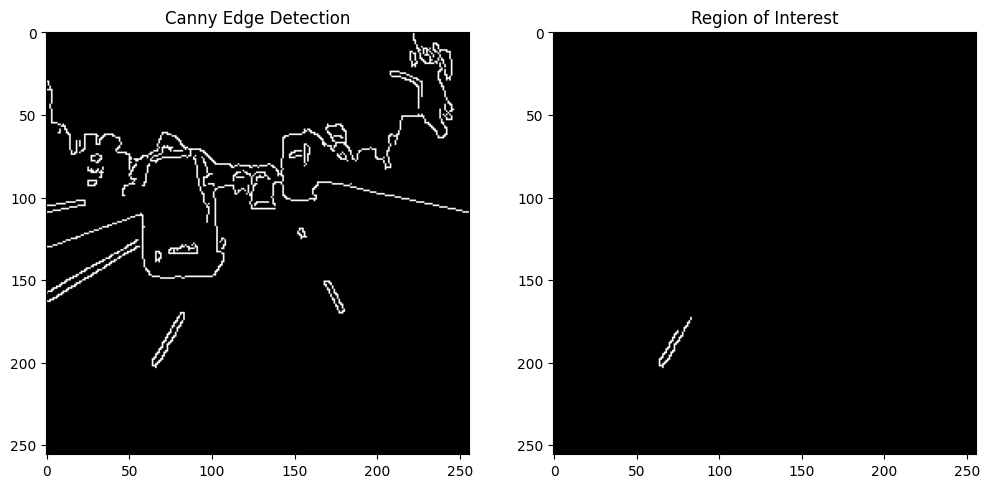

In [25]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Convert image data type if needed
sample_image = (val_images[0] * 255).astype(np.uint8)  # Replace with your sample image, convert to uint8

def canny_edge_detection(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Apply Gaussian blur to reduce noise
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    # Apply Canny edge detection
    edges = cv2.Canny(blur, 50, 150)
    return edges

def region_of_interest(image):
    height, width = image.shape[:2]
    # Define a triangular region of interest
    polygons = np.array([
        [(0, height), (width, height), (width // 2, height // 2)]
    ])
    mask = np.zeros_like(image)
    cv2.fillPoly(mask, polygons, 255)
    # Apply the mask to keep only the region of interest
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image

# Apply Canny Edge Detection
canny_edges = canny_edge_detection(sample_image)
roi_image = region_of_interest(canny_edges)

# Plot the results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Canny Edge Detection")
plt.imshow(canny_edges, cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Region of Interest")
plt.imshow(roi_image, cmap='gray')
plt.show()


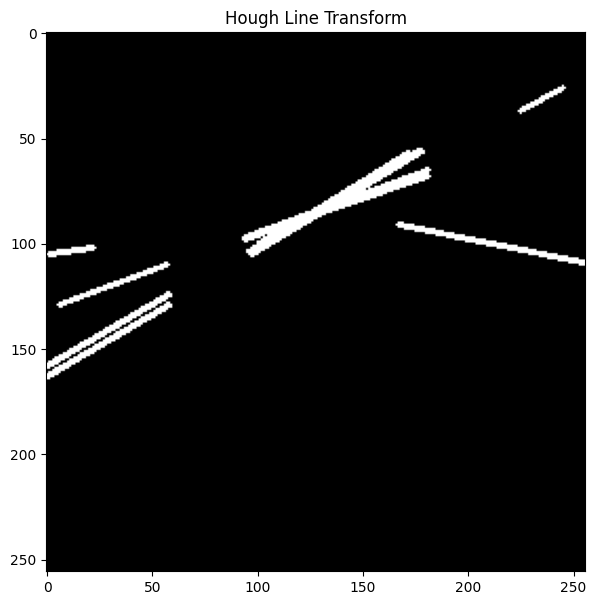

In [32]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Use the previously generated canny_edges or generate new edges if needed
edges = canny_edges  # Make sure canny_edges contains well-detected edges

def hough_transform(edges):
    # Perform Hough Line Transform
    lines = cv2.HoughLinesP(
        edges,
        rho=1,                # Distance resolution in pixels
        theta=np.pi / 180,    # Angle resolution in radians
        threshold=50,         # Minimum number of votes
        minLineLength=20,     # Minimum length of line
        maxLineGap=20         # Maximum allowed gap between line segments to treat them as a single line
    )

    # Create an image to draw the lines on
    line_image = np.zeros_like(edges)

    # Draw the lines on the black image if any lines were detected
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(line_image, (x1, y1), (x2, y2), 255, 2)

    return line_image

# Apply the Hough Transform
hough_lines = hough_transform(edges)

# Plot the result
plt.figure(figsize=(7, 7))
plt.imshow(hough_lines, cmap='gray')
plt.title('Hough Line Transform')
plt.show()


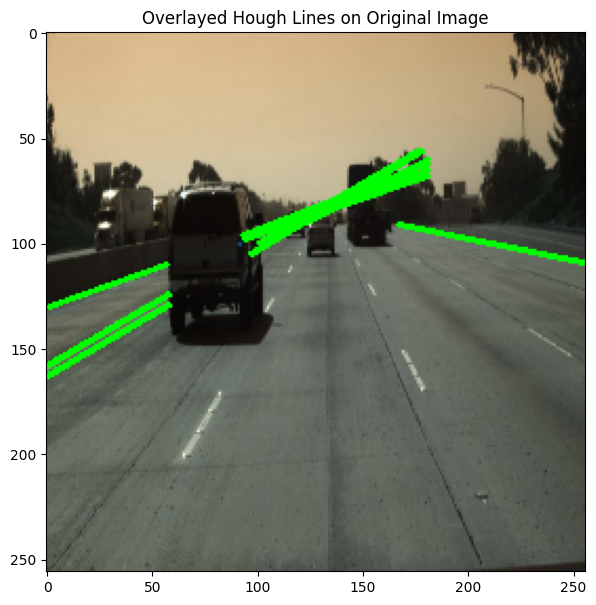

In [40]:
def overlay_lines_on_image(image, lines):
    # Create a copy of the original image to draw on
    line_image = np.copy(image)

    # If lines are detected, draw them on the original image
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(line_image, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Green lines with thickness 2

    return line_image

# Perform Hough Transform
lines = cv2.HoughLinesP(
    edges,
    rho=1,
    theta=np.pi / 180,
    threshold=50,
    minLineLength=50,
    maxLineGap=20
)

# Overlay the detected lines on the original image
overlayed_image = overlay_lines_on_image(sample_image, lines)

# Plot the overlayed image
plt.figure(figsize=(7, 7))
plt.imshow(overlayed_image)
plt.title('Overlayed Hough Lines on Original Image')
plt.show()
